<a href="https://colab.research.google.com/github/augurnaut/Build-2-Predictive-Model-about-Drug-Use-based-on-Demographic-and-Personality/blob/master/Build_Week_2_draft_predictive_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from ipywidgets import interact, fixed
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import json
import glob
import os
import category_encoders as ce # this one needs "import sys" idk why
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier

In [6]:
pd.set_option("display.max_rows", 100)
pd.set_option('display.max_columns',100)

In [7]:
from google.colab import files
uploaded = files.upload()

Saving drugs and personality send to Tally.csv to drugs and personality send to Tally.csv


In [8]:
# let's have a general look at what the dataframe looks like
# whenever we are running df.replace we need to rerun this cell
df = pd.read_csv('drugs and personality send to Tally.csv')
print(df.shape)
df.head()

(1885, 32)


,id,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation,alcohol,amphetamines,amyl_nitrite_consumption,benzos,caffeine,cannabis,chocolate,cocaine,crack,ecstasy,heroin,katamine,legal_highs,lsd,meth,mushrooms,nicotine,semeron,volatile_substance_abuse
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [9]:
# Let's look at the baseline; baseline is that around 
# 55% of people have never taken cocaine (CL0)
df['cocaine'].value_counts(normalize=True,ascending=True)

CL6    0.010080
CL5    0.021751
CL4    0.052520
CL1    0.084881
CL3    0.136870
CL2    0.143236
CL0    0.550663
Name: cocaine, dtype: float64

In [10]:
# when creating a dictionary for the categorical variables we want to see what we're working with
df.dtypes

id                            int64
age                         float64
gender                      float64
education                   float64
country                     float64
ethnicity                   float64
neuroticism                 float64
extraversion                float64
openness                    float64
agreeableness               float64
conscientiousness           float64
impulsiveness               float64
sensation                   float64
alcohol                      object
amphetamines                 object
amyl_nitrite_consumption     object
benzos                       object
caffeine                     object
cannabis                     object
chocolate                    object
cocaine                      object
crack                        object
ecstasy                      object
heroin                       object
katamine                     object
legal_highs                  object
lsd                          object
meth                        

In [11]:
# we want to limit the decimal places so that we can consistently replace in our 
# dictionary; as we will soon find out, some wonky things are happening behind 
# the scenes where we ultimately have to query specific observations from 
# specific features
df.round(decimals=5)

,id,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation,alcohol,amphetamines,amyl_nitrite_consumption,benzos,caffeine,cannabis,chocolate,cocaine,crack,ecstasy,heroin,katamine,legal_highs,lsd,meth,mushrooms,nicotine,semeron,volatile_substance_abuse
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,1884,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,CL5,CL0,CL0,CL0,CL4,CL5,CL4,CL0,CL0,CL0,CL0,CL0,CL3,CL3,CL0,CL0,CL0,CL0,CL5
1881,1885,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,CL5,CL0,CL0,CL0,CL5,CL3,CL4,CL0,CL0,CL2,CL0,CL0,CL3,CL5,CL4,CL4,CL5,CL0,CL0
1882,1886,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,CL4,CL6,CL5,CL5,CL6,CL6,CL6,CL4,CL0,CL4,CL0,CL2,CL0,CL2,CL0,CL2,CL6,CL0,CL0
1883,1887,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470,CL5,CL0,CL0,CL0,CL6,CL6,CL5,CL0,CL0,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL4,CL0,CL0


In [12]:
# let's look at what specific values we need to replace
df['country'].value_counts()

 0.96082    1044
-0.57009     557
-0.28519     118
 0.24923      87
-0.09765      54
 0.21128      20
-0.46841       5
Name: country, dtype: int64

In [13]:
# get descriptive statistics of numerical values of data
df.describe()

,id,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation
count,1885.000000,1885.00000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,945.294960,0.03461,-0.000256,-0.003806,0.355542,-0.309577,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,545.167641,0.87836,0.482588,0.950078,0.700335,0.166226,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,1.000000,-0.95197,-0.482460,-2.435910,-0.570090,-1.107020,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,474.000000,-0.95197,-0.482460,-0.611130,-0.570090,-0.316850,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,946.000000,-0.07854,-0.482460,-0.059210,0.960820,-0.316850,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,1417.000000,0.49788,0.482460,0.454680,0.960820,-0.316850,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,1888.000000,2.59171,0.482460,1.984370,0.960820,1.907250,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


In [14]:
# we have 19 'categorical' variables
# these simply measure the user intensity for each 'drug'
print(df.describe(exclude='number').shape)
df.describe(exclude='number')

(4, 19)


,alcohol,amphetamines,amyl_nitrite_consumption,benzos,caffeine,cannabis,chocolate,cocaine,crack,ecstasy,heroin,katamine,legal_highs,lsd,meth,mushrooms,nicotine,semeron,volatile_substance_abuse
count,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885
unique,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,5,7
top,CL5,CL0,CL0,CL0,CL6,CL6,CL6,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0
freq,759,976,1305,1000,1385,463,807,1038,1627,1021,1605,1490,1094,1069,1429,982,610,1877,1455


In [15]:
# list of categorical names; these are all of the 'drugs' being tested
df.describe(exclude='number').columns

Index(['alcohol', 'amphetamines', 'amyl_nitrite_consumption', 'benzos',
       'caffeine', 'cannabis', 'chocolate', 'cocaine', 'crack', 'ecstasy',
       'heroin', 'katamine', 'legal_highs', 'lsd', 'meth', 'mushrooms',
       'nicotine', 'semeron', 'volatile_substance_abuse'],
      dtype='object')

In [16]:
print(df.describe(include='number').shape)
df.describe(include='number')

(8, 13)


,id,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation
count,1885.000000,1885.00000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,945.294960,0.03461,-0.000256,-0.003806,0.355542,-0.309577,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,545.167641,0.87836,0.482588,0.950078,0.700335,0.166226,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,1.000000,-0.95197,-0.482460,-2.435910,-0.570090,-1.107020,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,474.000000,-0.95197,-0.482460,-0.611130,-0.570090,-0.316850,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,946.000000,-0.07854,-0.482460,-0.059210,0.960820,-0.316850,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,1417.000000,0.49788,0.482460,0.454680,0.960820,-0.316850,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,1888.000000,2.59171,0.482460,1.984370,0.960820,1.907250,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


In [17]:
# we have 13 numerical variables
df.describe(include='number').columns

Index(['id', 'age', 'gender', 'education', 'country', 'ethnicity',
       'neuroticism', 'extraversion', 'openness', 'agreeableness',
       'conscientiousness', 'impulsiveness', 'sensation'],
      dtype='object')

In [18]:
df['gender'].describe()

count    1885.000000
mean       -0.000256
std         0.482588
min        -0.482460
25%        -0.482460
50%        -0.482460
75%         0.482460
max         0.482460
Name: gender, dtype: float64

In [19]:
categorical_df = df.select_dtypes(exclude='number').copy()
categorical_df

,alcohol,amphetamines,amyl_nitrite_consumption,benzos,caffeine,cannabis,chocolate,cocaine,crack,ecstasy,heroin,katamine,legal_highs,lsd,meth,mushrooms,nicotine,semeron,volatile_substance_abuse
0,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,CL5,CL0,CL0,CL0,CL4,CL5,CL4,CL0,CL0,CL0,CL0,CL0,CL3,CL3,CL0,CL0,CL0,CL0,CL5
1881,CL5,CL0,CL0,CL0,CL5,CL3,CL4,CL0,CL0,CL2,CL0,CL0,CL3,CL5,CL4,CL4,CL5,CL0,CL0
1882,CL4,CL6,CL5,CL5,CL6,CL6,CL6,CL4,CL0,CL4,CL0,CL2,CL0,CL2,CL0,CL2,CL6,CL0,CL0
1883,CL5,CL0,CL0,CL0,CL6,CL6,CL5,CL0,CL0,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL4,CL0,CL0


In [20]:
df['country'].value_counts()

 0.96082    1044
-0.57009     557
-0.28519     118
 0.24923      87
-0.09765      54
 0.21128      20
-0.46841       5
Name: country, dtype: int64

In [21]:
cleanup_levels = {'age':{2.59171:5,1.82213:4,1.09449:3,0.49788000000000004:2,
                         -0.07854:1, -0.9519700000000001:0},
                  'gender':{0.48246000000000006:'Female', -0.48246000000000006:'Male'},
                  'education':{1.98437:8,1.16365:7,0.45468000000000003:6,-0.-0.059210000000000006:5,
                               -0.6111300000000001:4,-1.22751:3,-1.43719:2,
                               -1.73790:1, -2.43591:0},
                  'country':{-0.09765: 'Australia',0.24923:"Canada",
                             -0.46841000000000005:'New Zealand',-0.28519:"Other",
                             0.21128000000000002:'Republic of Ireland',0.9608200000000001:'UK',
                             -0.57009:'USA'},
                  'ethnicity':{-0.31685:6,0.11440:5,-1.10702:4,
                               -0.50212:3,-0.22166:2,0.12600:1, 
                               1.90725:0},
                  'alcohol':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 
                             'CL0':0},
                  'amphetamines':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,
                                  'CL1':1, 'CL0':0},
                  'amyl_nitrite_consumption':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,
                                              'CL2':2,'CL1':1, 'CL0':0},
                  'benzos':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 
                            'CL0':0},
                  'caffeine':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 
                              'CL0':0},
                  'cannabis':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 
                              'CL0':0},
                  'cocaine':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 
                             'CL0':0},
                  'crack':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 
                           'CL0':0},
                  'ecstasy':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 
                             'CL0':0},
                  'katamine':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 
                              'CL0':0},
                  'legal_highs':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0},
                  'lsd':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0},
                  'meth':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0},
                  'mushrooms':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0},
                  'nicotine':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0},
                  'semeron':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0},
                  'volatile_substance_abuse':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0},
                  'heroin':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0},
                  'chocolate':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0}}

In [22]:
# you have to pull the exact value; 
# we have modified again and again until it shows the correct values
df.age[3]

-0.9519700000000001

In [23]:
# this applies the dictionary to my dataframe
df.replace(cleanup_levels, inplace=True) # only run once

In [24]:
# RUN THIS CELL TO MAKE SURE THE DICTIONARY WAS APPLIED PROPERLY
df.head(20)

,id,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation,alcohol,amphetamines,amyl_nitrite_consumption,benzos,caffeine,cannabis,chocolate,cocaine,crack,ecstasy,heroin,katamine,legal_highs,lsd,meth,mushrooms,nicotine,semeron,volatile_substance_abuse
0,1,2.0,Female,5.0,UK,1.0,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,5,2,0,2,6,0,5,0,0,0,0,0,0,0,0,0,2,0,0
1,2,1.0,Male,8.0,UK,6.0,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,5,2,2,0,6,4,6,3,0,4,0,2,0,2,3,0,4,0,0
2,3,2.0,Male,5.0,UK,6.0,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,6,0,0,0,6,3,4,0,0,0,0,0,0,0,0,1,0,0,0
3,4,0.0,Female,7.0,UK,6.0,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,4,0,0,3,5,2,4,2,0,0,0,2,0,0,0,0,2,0,0
4,5,2.0,Female,8.0,UK,6.0,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,4,1,1,0,6,3,6,0,0,1,0,0,1,0,0,2,2,0,0
5,6,5.0,Female,3.0,Canada,6.0,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,2,0,0,0,6,0,4,0,0,0,0,0,0,0,0,0,6,0,0
6,7,3.0,Male,7.0,USA,6.0,-0.46725,-1.09207,-0.45174,-0.30172,0.93949,-0.21712,0.07987,6,0,0,0,6,1,5,0,0,0,0,0,0,0,0,0,6,0,0
7,8,2.0,Male,1.0,UK,6.0,-1.32828,1.93886,-0.84732,-0.30172,1.63088,0.19268,-0.52593,5,0,0,0,6,0,4,0,0,0,0,0,0,0,0,0,0,0,0
8,9,2.0,Female,5.0,Canada,6.0,0.62967,2.57309,-0.97631,0.76096,1.13407,-1.37983,-1.54858,4,0,0,0,6,0,6,0,0,0,0,0,0,0,0,0,6,0,0
9,10,4.0,Male,7.0,UK,6.0,-0.24649,0.00332,-1.42424,0.59042,0.12331,-1.37983,-0.84637,6,1,0,1,6,1,6,0,0,0,0,0,0,0,0,0,6,0,0


In [25]:
# you have to pull the exact value; 
# we have modified again and again until it shows the correct values
df.age[3]

0.0

In [26]:
# we see which floats have been successfully changed; we have successfully
# changed some numeric values to categorical ones and categoricals (CL0 to CL6)
# to simple integers
df.dtypes

id                            int64
age                         float64
gender                       object
education                   float64
country                      object
ethnicity                   float64
neuroticism                 float64
extraversion                float64
openness                    float64
agreeableness               float64
conscientiousness           float64
impulsiveness               float64
sensation                   float64
alcohol                       int64
amphetamines                  int64
amyl_nitrite_consumption      int64
benzos                        int64
caffeine                      int64
cannabis                      int64
chocolate                     int64
cocaine                       int64
crack                         int64
ecstasy                       int64
heroin                        int64
katamine                      int64
legal_highs                   int64
lsd                           int64
meth                        

In [27]:
coredraft1 = df.drop(['amphetamines','amyl_nitrite_consumption','benzos','crack',
                'ecstasy','heroin','katamine','meth','semeron',
                'volatile_substance_abuse','id'], axis=1)

In [28]:
# our initial dataframe has 32 columns but we have reduced it to 20
print(coredraft1.info())
coredraft1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1885 non-null   float64
 1   gender             1885 non-null   object 
 2   education          1885 non-null   float64
 3   country            1885 non-null   object 
 4   ethnicity          1885 non-null   float64
 5   neuroticism        1885 non-null   float64
 6   extraversion       1885 non-null   float64
 7   openness           1885 non-null   float64
 8   agreeableness      1885 non-null   float64
 9   conscientiousness  1885 non-null   float64
 10  impulsiveness      1885 non-null   float64
 11  sensation          1885 non-null   float64
 12  alcohol            1885 non-null   int64  
 13  caffeine           1885 non-null   int64  
 14  cannabis           1885 non-null   int64  
 15  chocolate          1885 non-null   int64  
 16  cocaine            1885 

,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation,alcohol,caffeine,cannabis,chocolate,cocaine,legal_highs,lsd,mushrooms,nicotine
0,2.0,Female,5.0,UK,1.0,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,5,6,0,5,0,0,0,0,2
1,1.0,Male,8.0,UK,6.0,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,5,6,4,6,3,0,2,0,4
2,2.0,Male,5.0,UK,6.0,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,6,6,3,4,0,0,0,1,0
3,0.0,Female,7.0,UK,6.0,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,4,5,2,4,2,0,0,0,2
4,2.0,Female,8.0,UK,6.0,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,4,6,3,6,0,1,0,2,2


In [29]:
# in general, we need a sample of at least 30 and since the Republic of Ireland
# and New Zealand have less than 30 observations we want to take these out
coredraft1.country.value_counts()

UK                     1044
USA                     557
Other                   118
Canada                   87
Australia                54
Republic of Ireland      20
New Zealand               5
Name: country, dtype: int64

In [30]:
corecountriesdraft1 = coredraft1[~coredraft1.country.str.contains('New Zealand')]
corecountriesdraft1.country.value_counts()

UK                     1044
USA                     557
Other                   118
Canada                   87
Australia                54
Republic of Ireland      20
Name: country, dtype: int64

In [31]:
corecountries = corecountriesdraft1[~corecountriesdraft1.country.str.contains('Republic of Ireland')]
corecountries.country.value_counts()

UK           1044
USA           557
Other         118
Canada         87
Australia      54
Name: country, dtype: int64

In [32]:
corecountries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1860 entries, 0 to 1883
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1860 non-null   float64
 1   gender             1860 non-null   object 
 2   education          1860 non-null   float64
 3   country            1860 non-null   object 
 4   ethnicity          1860 non-null   float64
 5   neuroticism        1860 non-null   float64
 6   extraversion       1860 non-null   float64
 7   openness           1860 non-null   float64
 8   agreeableness      1860 non-null   float64
 9   conscientiousness  1860 non-null   float64
 10  impulsiveness      1860 non-null   float64
 11  sensation          1860 non-null   float64
 12  alcohol            1860 non-null   int64  
 13  caffeine           1860 non-null   int64  
 14  cannabis           1860 non-null   int64  
 15  chocolate          1860 non-null   int64  
 16  cocaine            1860 

In [33]:
# let's double check what the size of our train set should be
1860*.85

1581.0

In [34]:
#Let's split the data set into 85% for the train set and 15% for the test set

train_data, test_data = np.split(corecountries, [int(.85*len(corecountries))])

test = test_data
train = train_data
target = 'cocaine'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)
train_features = train.drop(columns=[target])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the features 
features = numeric_features + categorical_features
X_train = train.drop(columns=target)
y_train = train[target]
X_test = test.drop(columns=target)
y_test = test[target]
X_val = val.drop(columns=target)
y_val = val[target]
print(features)

['age', 'education', 'ethnicity', 'neuroticism', 'extraversion', 'openness', 'agreeableness', 'conscientiousness', 'impulsiveness', 'sensation', 'alcohol', 'caffeine', 'cannabis', 'chocolate', 'legal_highs', 'lsd', 'mushrooms', 'nicotine', 'gender', 'country']


In [35]:
# as calculated above, this is 85% of our data
print(train_data.shape)
train_data.head()

(1581, 21)


,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation,alcohol,caffeine,cannabis,chocolate,cocaine,legal_highs,lsd,mushrooms,nicotine
0,2.0,Female,5.0,UK,1.0,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,5,6,0,5,0,0,0,0,2
1,1.0,Male,8.0,UK,6.0,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,5,6,4,6,3,0,2,0,4
2,2.0,Male,5.0,UK,6.0,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,6,6,3,4,0,0,0,1,0
3,0.0,Female,7.0,UK,6.0,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,4,5,2,4,2,0,0,0,2
4,2.0,Female,8.0,UK,6.0,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,4,6,3,6,0,1,0,2,2


In [36]:
# stratifyying is a possibility; change from target to some other feature
train_data['country'].value_counts()

UK           909
USA          448
Other        101
Canada        76
Australia     47
Name: country, dtype: int64

In [37]:
print(test_data.shape)
test_data.head()

(279, 21)


,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation,alcohol,caffeine,cannabis,chocolate,cocaine,legal_highs,lsd,mushrooms,nicotine
1603,2.0,Female,5.0,UK,6.0,-1.55078,1.45421,0.44585,0.43852,0.58489,-0.71126,-1.18084,5,6,2,6,0,0,1,0,2
1604,2.0,Female,7.0,UK,6.0,-0.79151,0.32197,-0.01928,-0.15487,1.13407,-0.21712,-0.21575,5,6,1,5,0,0,0,0,2
1605,1.0,Male,4.0,USA,6.0,-0.24649,-1.09207,2.44904,-0.91699,-0.65253,1.29221,0.76540,3,5,3,4,3,6,3,3,6
1606,1.0,Female,6.0,UK,6.0,-0.14882,-1.09207,-1.68062,0.94156,0.75830,-0.71126,-2.07848,4,6,0,6,0,0,0,0,0
1607,3.0,Female,6.0,UK,6.0,0.22393,0.63779,-0.97631,0.76096,-0.52745,-1.37983,-2.07848,5,6,0,5,0,0,0,0,2


In [38]:
test_data['country'].value_counts()

UK           135
USA          109
Other         17
Canada        11
Australia      7
Name: country, dtype: int64

In [39]:
X_train.info

<bound method DataFrame.info of       age  gender  education country  ethnicity  neuroticism  extraversion  \
513   2.0    Male        1.0      UK    6.00000      0.91093      -0.30033   
358   1.0  Female        4.0      UK    6.00000     -0.58016       1.58487   
383   3.0  Female        6.0      UK   -1.10702     -0.24649       0.16767   
729   0.0    Male        4.0      UK    6.00000     -0.79151       1.28610   
906   0.0    Male        4.0     USA    5.00000     -0.24649       0.00332   
...   ...     ...        ...     ...        ...          ...           ...   
1053  1.0  Female        4.0     USA    6.00000      0.22393      -0.15487   
440   1.0  Female        7.0      UK    6.00000     -0.92104       0.00332   
1239  1.0  Female        6.0      UK    6.00000     -1.32828       0.80523   
872   1.0  Female        7.0     USA    6.00000      0.22393      -1.09207   
1154  0.0  Female        4.0      UK    6.00000      0.22393      -0.15487   

      openness  agreeableness  

In [40]:
y_test

1603    0
1604    0
1605    3
1606    0
1607    0
       ..
1879    0
1880    0
1881    0
1882    4
1883    0
Name: cocaine, Length: 279, dtype: int64

In [41]:
# here we're preparing to do a logistic regression model
encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()
model = LogisticRegression(max_iter=1000,solver='lbfgs')

X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_train_scaled = scaler.fit_transform(X_train_imputed)
model.fit(X_train_scaled, y_train)

X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)
y_pred

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 3, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 2, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 3, 0, 1, 0, 0,
       0, 3, 0, 0, 3, 0, 2, 0, 0, 3, 1, 2, 3, 0, 2, 2, 0, 2, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 2, 0, 0, 4, 3, 1, 3, 1, 0, 0, 0, 1, 2, 0, 3, 0, 3,
       1, 2, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 3, 3, 0, 1, 0, 0, 0, 0, 3, 0,
       3, 0, 0, 3, 0, 0, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1, 0, 1, 0, 3, 3, 0,
       0, 0, 3, 3, 0, 3, 2, 0, 0, 0, 3, 3, 3, 1, 0, 1, 3, 3, 3, 3, 3, 3,
       2, 0, 3, 0, 3, 1, 4, 3, 0, 0, 3, 0, 3, 3, 3])

In [42]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [43]:
# the R-squared, or coefficient of determination
model.score(X_train_scaled,y_train)

0.6129032258064516

In [44]:
# for a mean baseline we can see that, since our R-squared is negative, the
# baseline is probably not the right fit
from sklearn.metrics import mean_absolute_error, r2_score
guess = df['cocaine'].mean()
y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error: {mae:.2f}')
r2 = r2_score(y_train, y_pred)
print('R squared: ', r2)

Train Error: 1.31
R squared:  -0.00042760838039557214


In [45]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)

In [46]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=15)

X_train_selected = selector.fit_transform(X_train, y_train)

In [47]:
X_train_selected.shape

(1302, 15)

In [48]:
selected_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
age
gender_Male
gender_Female
country_UK
country_USA
openness
agreeableness
conscientiousness
impulsiveness
sensation
cannabis
legal_highs
lsd
mushrooms
nicotine


Features not selected:
education
country_Canada
country_Other
country_Australia
ethnicity
neuroticism
extraversion
alcohol
caffeine
chocolate


In [49]:
X_val.shape

(279, 20)

In [50]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_val = encoder.fit_transform(X_val)

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns) + 1):
  print(f'{k} features')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_val)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_val, y_pred)
  print(f'Test MAE: {mae:,.4f} \n')

1 features
Test MAE: 1.0593 

2 features
Test MAE: 1.0167 

3 features
Test MAE: 1.0039 

4 features
Test MAE: 0.9970 

5 features
Test MAE: 0.9875 

6 features
Test MAE: 0.9873 

7 features
Test MAE: 0.9885 

8 features
Test MAE: 0.9914 

9 features
Test MAE: 0.9928 

10 features
Test MAE: 1.0002 

11 features
Test MAE: 0.9985 

12 features
Test MAE: 0.9985 

13 features
Test MAE: 0.9974 

14 features
Test MAE: 0.9858 

15 features
Test MAE: 0.9868 

16 features
Test MAE: 0.9895 

17 features
Test MAE: 0.9877 

18 features
Test MAE: 0.9898 

19 features
Test MAE: 0.9945 

20 features
Test MAE: 0.9961 

21 features
Test MAE: 0.9905 

22 features
Test MAE: 0.9894 

23 features
Test MAE: 0.9943 

24 features
Test MAE: 0.9963 

25 features
Test MAE: 0.9963 



In [52]:
selector = SelectKBest(score_func=f_regression, k=15)
X_train_selected = selector.fit_transform(X_train, y_train)

In [53]:
selected_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
age
gender_Male
gender_Female
country_UK
country_USA
openness
agreeableness
conscientiousness
impulsiveness
sensation
cannabis
legal_highs
lsd
mushrooms
nicotine


Features not selected:
education
country_Canada
country_Other
country_Australia
ethnicity
neuroticism
extraversion
alcohol
caffeine
chocolate


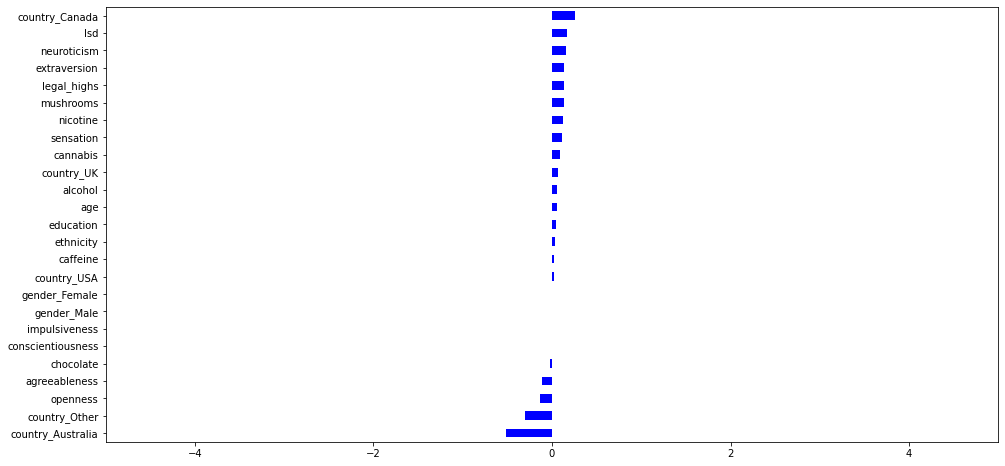

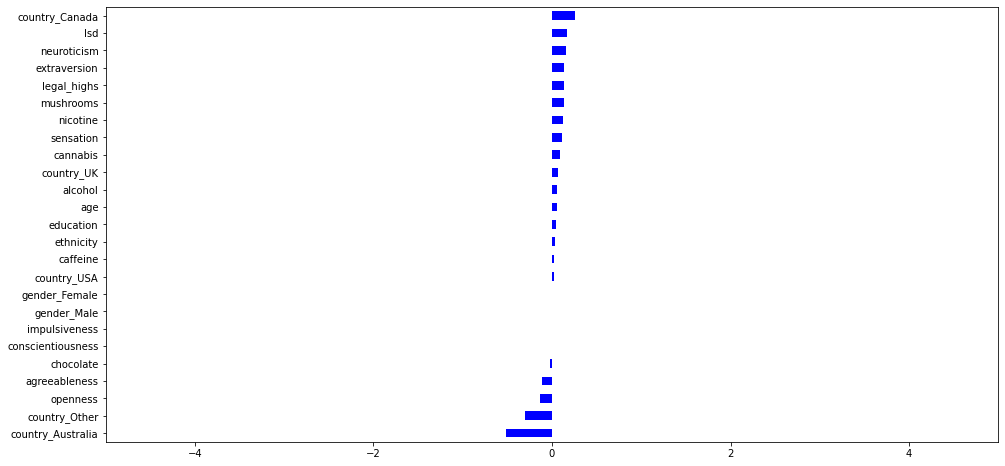

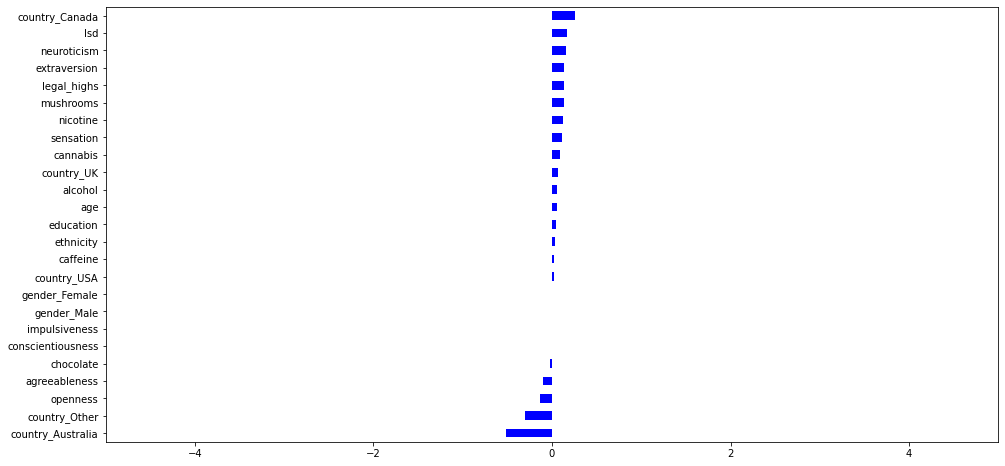

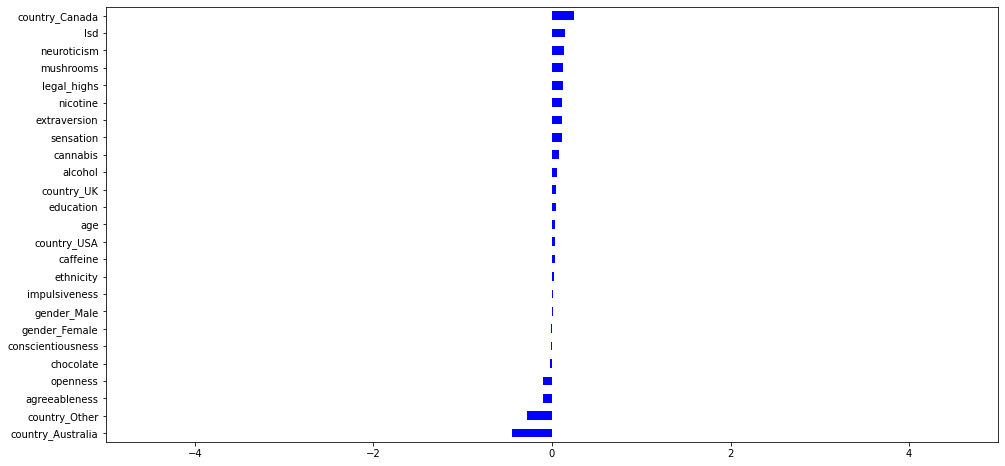

In [54]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

for alpha in [0.00000000001, 0.00001, 0.001, .1]:
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Get Test MAE
    mae = mean_absolute_error(y_val, y_pred)
    display(HTML(f'Test Mean Absolute Error: {mae:,.4f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='blue')
    plt.xlim(-5,5)
    plt.show()

In [55]:
# alpha at .001 seems to be the lowest MAE that I tested and the other alphas 
# don't go any lower than MAE of .9958 so we'll go with that
linridge = Ridge(alpha=0.001).fit(X_train, y_train)

print('R-squared score (train): {:.3f}'
     .format(linridge.score(X_train, y_train)))

R-squared score (train): 0.362


In [56]:
linridge = Ridge(alpha=0.001).fit(X_val, y_val)

print('R-squared score (validate): {:.3f}'
     .format(linridge.score(X_val, y_val)))

R-squared score (validate): 0.327


It seems like linear regression doesn't do a very good job at explaining variability of our target (since ideally we'd want an R-squared score of at least 80% but our R-squared scores are below 40% for both the train and test sets) so it's probably best that we stick with classification

In [57]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    SelectKBest(f_regression, k=18), 
    Ridge(alpha=1.0)
)

k = 3
scoresLM = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scoresLM)

MAE for 3 folds: [0.93797008 0.89577414 0.95985892]


In [58]:
-scoresLM.mean()

0.9312010478698497

In [59]:
#Let's split the data set into 85% for the train set and 15% for the test set

train_data, test_data = np.split(corecountries, [int(.85*len(corecountries))])

test = test_data
train = train_data
target = 'cocaine'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)
train_features = train.drop(columns=[target])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the features 
features = numeric_features + categorical_features
X_train = train.drop(columns=target)
y_train = train[target]
X_test = test.drop(columns=target)
y_test = test[target]
X_val = val.drop(columns=target)
y_val = val[target]
print(features)

['age', 'education', 'ethnicity', 'neuroticism', 'extraversion', 'openness', 'agreeableness', 'conscientiousness', 'impulsiveness', 'sensation', 'alcohol', 'caffeine', 'cannabis', 'chocolate', 'legal_highs', 'lsd', 'mushrooms', 'nicotine', 'gender', 'country']


In [60]:
# (1)XGBC 1st try, default parameters 

from xgboost import XGBClassifier

pipeline101 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100,
                  random_state=42,
                  n_jobs=-1)
)
pipeline101.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'country'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2
NaN      -2
dtype: int64},
                                         {'col': 'country',
                                          'data_type': dtype('O'),
                                          'mapping': UK           1
USA          2
Canada       3
Other        4
Australia    5
NaN         -2
dtype: int64}],
                                return_df...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, 

In [61]:
y_pred = pipeline101.predict(X_test)
print('Training Accuracy:', pipeline101.score(X_train, y_train))
print('Validation Accuracy:', pipeline101.score(X_val, y_val))
print('Test Accuracy', accuracy_score(y_test, y_pred))

Training Accuracy: 0.793394777265745
Validation Accuracy: 0.5698924731182796
Test Accuracy 0.6487455197132617


In [62]:
k = 8
scoresLMp101 = cross_val_score(pipeline101, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scoresLMp101)
print(f'Mean of cross-validation scores for {k} folds:',-scoresLMp101.mean())

MAE for 8 folds: [0.81595092 0.74846626 0.87116564 0.88957055 0.8404908  0.8404908
 0.74074074 0.69753086]
Mean of cross-validation scores for 8 folds: 0.8055508217829281


In [63]:
# (1)XGBC 2nd try; changed max depth and random state

from xgboost import XGBClassifier

pipeline102 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(booster= 'gbtree',n_estimators=100, max_depth=5,
                  random_state=30,
                  n_jobs=-1)
)
pipeline102.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'country'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2
NaN      -2
dtype: int64},
                                         {'col': 'country',
                                          'data_type': dtype('O'),
                                          'mapping': UK           1
USA          2
Canada       3
Other        4
Australia    5
NaN         -2
dtype: int64}],
                                return_df...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, 

In [64]:
y_pred = pipeline102.predict(X_test)
print('Training Accuracy:', pipeline102.score(X_train, y_train))
print('Validation Accuracy:', pipeline102.score(X_val, y_val))
print('Test Accuracy', accuracy_score(y_test, y_pred))

Training Accuracy: 0.966973886328725
Validation Accuracy: 0.5949820788530465
Test Accuracy 0.6451612903225806


In [65]:
k = 8
scoresLMp102 = cross_val_score(pipeline102, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scoresLMp102)
print(f'Mean of cross-validation scores for {k} folds:',-scoresLMp102.mean())

MAE for 8 folds: [0.82822086 0.78527607 0.87116564 0.94478528 0.83435583 0.74846626
 0.77160494 0.82716049]
Mean of cross-validation scores for 8 folds: 0.8263794213436341


In [66]:
# (1)XGBC 3rd try; reduced estimators to help with overfitting
# it looks like this had the most reasonable fit; the train isn't overfitting
# and the disparity between training and validation is smaller than the rest

from xgboost import XGBClassifier

pipeline103 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(booster= 'gbtree',n_estimators=30, max_depth=5,
                  random_state=30,
                  n_jobs=-1)
)
pipeline103.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'country'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2
NaN      -2
dtype: int64},
                                         {'col': 'country',
                                          'data_type': dtype('O'),
                                          'mapping': UK           1
USA          2
Canada       3
Other        4
Australia    5
NaN         -2
dtype: int64}],
                                return_df...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, 

In [67]:
y_pred = pipeline103.predict(X_test)
print('Training Accuracy:', pipeline103.score(X_train, y_train))
print('Validation Accuracy:', pipeline103.score(X_val, y_val))
print('Test Accuracy', accuracy_score(y_test, y_pred))

Training Accuracy: 0.8402457757296466
Validation Accuracy: 0.5985663082437276
Test Accuracy 0.6630824372759857


In [68]:
# (1)XGBC 4th try; reduced estimators and increased depth

from xgboost import XGBClassifier

pipeline104 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(booster= 'gbtree',n_estimators=10, max_depth=7,
                  random_state=30,
                  n_jobs=-1)
)
pipeline104.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'country'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2
NaN      -2
dtype: int64},
                                         {'col': 'country',
                                          'data_type': dtype('O'),
                                          'mapping': UK           1
USA          2
Canada       3
Other        4
Australia    5
NaN         -2
dtype: int64}],
                                return_df...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, 

In [69]:
y_pred = pipeline104.predict(X_test)
print('Training Accuracy:', pipeline104.score(X_train, y_train))
print('Validation Accuracy:', pipeline104.score(X_val, y_val))
print('Test Accuracy', accuracy_score(y_test, y_pred))

Training Accuracy: 0.8771121351766513
Validation Accuracy: 0.5806451612903226
Test Accuracy 0.6344086021505376


In [70]:
# randomforestclassifier 1st try
pipelinerf101 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=15, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipelinerf101.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'country'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2
NaN      -2
dtype: int64},
                                         {'col': 'country',
                                          'data_type': dtype('O'),
                                          'mapping': UK           1
USA          2
Canada       3
Other        4
Australia    5
NaN         -2
dtype: int64}],
                                return_df...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        

In [71]:
y_pred = pipelinerf101.predict(X_test)
print('Training Accuracy:', pipelinerf101.score(X_train, y_train))
print('Validation Accuracy:', pipelinerf101.score(X_val, y_val))
print('Test Accuracy', accuracy_score(y_test, y_pred))

Training Accuracy: 0.9938556067588326
Validation Accuracy: 0.5591397849462365
Test Accuracy 0.6379928315412187


In [72]:
# randomforestclassifier 2nd try; increase estimators, limit max_depth and 
# change max features for log2 from auto (which was square root)
pipelinerf102 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=30,criterion='entropy',max_depth=5,
                           random_state=42, n_jobs=-1, max_features='log2',
                           min_impurity_decrease=.11)
)

# Fit on train, score on val
pipelinerf102.fit(X_train, y_train)
y_pred = pipelinerf102.predict(X_test)
print('Training Accuracy:', pipelinerf102.score(X_train, y_train))
print('Validation Accuracy:', pipelinerf102.score(X_val, y_val))
print('Test Accuracy', accuracy_score(y_test, y_pred))

Training Accuracy: 0.5376344086021505
Validation Accuracy: 0.5376344086021505
Test Accuracy 0.6272401433691757


In [73]:
# randomforestclassifier 3rd try; increaset min_impurity_decrease and reverted 
# max_features back to auto; it seems like min_impurity_decrease heavily 
# affected training and validation; changing it back to zero
pipelinerf103 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=30,criterion='entropy',max_depth=5,
                           random_state=42, n_jobs=-1,min_impurity_decrease=.11)
)

# Fit on train, score on val
pipelinerf103.fit(X_train, y_train)
y_pred = pipelinerf103.predict(X_test)
print('Training Accuracy:', pipelinerf103.score(X_train, y_train))
print('Validation Accuracy:', pipelinerf103.score(X_val, y_val))
print('Test Accuracy', accuracy_score(y_test, y_pred))

Training Accuracy: 0.5376344086021505
Validation Accuracy: 0.5376344086021505
Test Accuracy 0.6272401433691757


In [74]:
# randomforestclassifier 4th try
# this produces the highest test accuracy of 67.4% but this is something to look
# at after the fact; we need to focus on the train and val accuracies
pipelinerf104 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=30,criterion='entropy',max_depth=10,
                           random_state=42, n_jobs=-1,
                           min_impurity_decrease=0)
)

# Fit on train, score on val
pipelinerf104.fit(X_train, y_train)
y_pred = pipelinerf104.predict(X_test)
print('Training Accuracy:', pipelinerf104.score(X_train, y_train))
print('Validation Accuracy:', pipelinerf104.score(X_val, y_val))
print('Test Accuracy', accuracy_score(y_test, y_pred))

Training Accuracy: 0.9761904761904762
Validation Accuracy: 0.5734767025089605
Test Accuracy 0.6881720430107527


In [75]:
# THIS IS THE MODEL WE'RE GOING WITH; USE THIS ONE
# (1)XGBC 3rd try; reduced estimators to help with overfitting
# it looks like this had the most reasonable fit; the train isn't overfitting
# and the disparity between training and validation is smaller than the rest

from xgboost import XGBClassifier

pipeline103 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(booster= 'gbtree',n_estimators=30, max_depth=5,
                  random_state=30,
                  n_jobs=-1)
)
pipeline103.fit(X_train, y_train)

y_pred = pipeline103.predict(X_test)
print('Training Accuracy:', pipeline103.score(X_train, y_train))
print('Validation Accuracy:', pipeline103.score(X_val, y_val))
print('Test Accuracy', accuracy_score(y_test, y_pred))

Training Accuracy: 0.8402457757296466
Validation Accuracy: 0.5985663082437276
Test Accuracy 0.6630824372759857


In [76]:
k = 8
scoresLMp103 = cross_val_score(pipeline103, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scoresLMp103)
print(f'Mean of cross-validation scores for {k} folds:',-scoresLMp103.mean())

MAE for 8 folds: [0.80368098 0.77300613 0.86503067 0.87116564 0.86503067 0.74233129
 0.79012346 0.74074074]
Mean of cross-validation scores for 8 folds: 0.8063886995379839


In [77]:
y_pred

array([1, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 2, 3, 0, 0, 0, 0, 0, 3, 0, 3, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 3, 0, 2, 4, 0, 3, 2, 0, 3, 1, 0, 4, 0, 0, 2, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 5, 3, 2, 3, 0, 0, 3, 2, 0, 0, 0, 1, 2, 2, 0, 0, 0,
       1, 3, 0, 3, 3, 0, 2, 0, 1, 3, 0, 0, 3, 0, 0, 1, 0, 0, 0, 3, 2, 2,
       0, 4, 2, 0, 0, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       2, 0, 2, 4, 2, 0, 3, 0, 0, 0, 0, 3, 3, 1, 0, 1, 3, 3, 3, 0, 3, 3,
       0, 2, 0, 0, 3, 1, 3, 2, 0, 0, 0, 0, 0, 3, 3])

In [78]:
df['cocaine'].value_counts(normalize=True)

0    0.550663
2    0.143236
3    0.136870
1    0.084881
4    0.052520
5    0.021751
6    0.010080
Name: cocaine, dtype: float64

In [79]:
look = pd.DataFrame(y_pred)
look.columns = ['cocaine']
look['cocaine'].value_counts(normalize=True)

0    0.666667
2    0.121864
3    0.118280
1    0.071685
4    0.017921
5    0.003584
Name: cocaine, dtype: float64

In [80]:
from xgboost import XGBClassifier

pipeline103 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(booster= 'gbtree',n_estimators=30, max_depth=5,
                  random_state=30,
                  n_jobs=-1)
)
pipeline103.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'country'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2
NaN      -2
dtype: int64},
                                         {'col': 'country',
                                          'data_type': dtype('O'),
                                          'mapping': UK           1
USA          2
Canada       3
Other        4
Australia    5
NaN         -2
dtype: int64}],
                                return_df...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, 

In [81]:
y_pred = pipeline103.predict(X_test)

In [82]:
print('Training Accuracy:', pipeline103.score(X_train, y_train))
print('Validation Accuracy:', pipeline103.score(X_val, y_val))
print('Test Accuracy', accuracy_score(y_test, y_pred))

Training Accuracy: 0.8402457757296466
Validation Accuracy: 0.5985663082437276
Test Accuracy 0.6630824372759857


In [83]:
!pip install eli5

import eli5
from eli5.sklearn import PermutationImportance

# Ignore warnings

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

pipeline103 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(booster= 'gbtree',n_estimators=30, max_depth=5,
                  random_state=30,
                  n_jobs=-1)
)
pipeline103.fit(X_train_transformed, y_train)


feature_names = X_val.columns.tolist()

permuter = PermutationImportance(
    pipeline103,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

     |████████████████████████████████| 112kB 8.1MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


Weight,Feature
0.0631 ± 0.0439,lsd
0.0487 ± 0.0397,age
0.0337 ± 0.0167,cannabis
0.0208 ± 0.0228,nicotine
0.0186 ± 0.0054,mushrooms
0.0172 ± 0.0084,openness
0.0122 ± 0.0278,legal_highs
0.0122 ± 0.0206,conscientiousness
0.0050 ± 0.0167,education
0.0036 ± 0.0000,gender


In [87]:
from sklearn.inspection import permutation_importance
pipeline103 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(booster= 'gbtree',n_estimators=30, max_depth=5,
                  random_state=30,
                  n_jobs=-1))
pipeline103.fit(X_val, y_val)
pi = permutation_importance(pipeline103,
                            X_val,
                            y_val,
                            random_state=42,
                            n_jobs=-1)
p_importance = pd.DataFrame({'feature' : X_test.columns,
                             'weight'  : pi.importances_mean,
                             'std'     : pi.importances_std})

p_importance.sort_values('weight', ascending=False).tail(10)

,feature,weight,std
8,agreeableness,0.030108,0.006249
2,education,0.029391,0.009724
9,conscientiousness,0.029391,0.005268
18,mushrooms,0.024373,0.009180
10,impulsiveness,0.018638,0.004180
12,alcohol,0.012186,0.002867
3,country,0.008602,0.003655
13,caffeine,0.004301,0.002682
1,gender,0.000717,0.002682
4,ethnicity,0.000000,0.000000


In [88]:
column  = 'lsd'

# Fit without column
pipeline103.fit(X_train.drop(columns=column), y_train)
score_without = pipeline103.score(X_val.drop(columns=column), y_val.drop(columns=column))
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline103.fit(X_train, y_train)
score_with = pipeline103.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without lsd: 0.5627240143369175
Validation Accuracy with lsd: 0.6021505376344086
Drop-Column Importance for lsd: 0.03942652329749108


In [89]:
feature = 'lsd'
print(X_val[feature].head())
print()
print(X_val[feature].value_counts())

718     2
1301    4
1355    6
185     1
1389    0
Name: lsd, dtype: int64

0    161
1     42
2     28
3     24
4     13
5      7
6      4
Name: lsd, dtype: int64


In [90]:
corefeatures = df.drop(['amphetamines','amyl_nitrite_consumption','benzos',
                        'crack','ecstasy','heroin','katamine','meth','semeron',
                        'volatile_substance_abuse','id','agreeableness',
                        'caffeine','conscientiousness','gender','sensation',], 
                       axis=1)

In [91]:
corefeatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            1885 non-null   float64
 1   education      1885 non-null   float64
 2   country        1885 non-null   object 
 3   ethnicity      1885 non-null   float64
 4   neuroticism    1885 non-null   float64
 5   extraversion   1885 non-null   float64
 6   openness       1885 non-null   float64
 7   impulsiveness  1885 non-null   float64
 8   alcohol        1885 non-null   int64  
 9   cannabis       1885 non-null   int64  
 10  chocolate      1885 non-null   int64  
 11  cocaine        1885 non-null   int64  
 12  legal_highs    1885 non-null   int64  
 13  lsd            1885 non-null   int64  
 14  mushrooms      1885 non-null   int64  
 15  nicotine       1885 non-null   int64  
dtypes: float64(7), int64(8), object(1)
memory usage: 235.8+ KB


In [92]:
corefeatures.country.value_counts()

UK                     1044
USA                     557
Other                   118
Canada                   87
Australia                54
Republic of Ireland      20
New Zealand               5
Name: country, dtype: int64

In [93]:
train_data, test_data = np.split(corefeatures, [int(.85*len(corefeatures))])

test = test_data
train = train_data
target = 'cocaine'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)
train_features = train.drop(columns=[target])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the features 
features = numeric_features + categorical_features
X_train = train.drop(columns=target)
y_train = train[target]
X_test = test.drop(columns=target)
y_test = test[target]
X_val = val.drop(columns=target)
y_val = val[target]
print(features)

['age', 'education', 'ethnicity', 'neuroticism', 'extraversion', 'openness', 'impulsiveness', 'alcohol', 'cannabis', 'chocolate', 'legal_highs', 'lsd', 'mushrooms', 'nicotine', 'country']


In [94]:
from xgboost import XGBClassifier

pipeline103 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(booster= 'gbtree',n_estimators=30, max_depth=5,
                  random_state=30,
                  n_jobs=-1)
)
pipeline103.fit(X_train, y_train)

y_pred = pipeline103.predict(X_test)
print('Training Accuracy:', pipeline103.score(X_train, y_train))
print('Validation Accuracy:', pipeline103.score(X_val, y_val))
print('Test Accuracy', accuracy_score(y_test, y_pred))

Training Accuracy: 0.8112206216830933
Validation Accuracy: 0.6007067137809188
Test Accuracy 0.6466431095406361


In [95]:
import plotly.express as px
px.scatter_3d(
    corefeatures,
    x='lsd', 
    y='neuroticism', 
    z='cocaine',  
    title='Level of cocaine use relative to LSD use and levels of Neuroticism'
)

In [96]:
df = pd.read_csv('drugs and personality send to Tally.csv')
print(df.shape)
df.head()

(1885, 32)


,id,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation,alcohol,amphetamines,amyl_nitrite_consumption,benzos,caffeine,cannabis,chocolate,cocaine,crack,ecstasy,heroin,katamine,legal_highs,lsd,meth,mushrooms,nicotine,semeron,volatile_substance_abuse
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [97]:
df.age.value_counts()

-0.95197    643
-0.07854    481
 0.49788    356
 1.09449    294
 1.82213     93
 2.59171     18
Name: age, dtype: int64

In [98]:
cleanup_levels = {'age':{2.59171:'65+',1.82213:'55-64',1.09449:'45-54',0.49788000000000004:'34-44',
                         -0.07854:'25-34', -0.9519700000000001:'18-24'},
                  'gender':{0.48246000000000006:'Female', -0.48246000000000006:'Male'},
                  'education':{1.98437:8,1.16365:7,0.45468000000000003:6,-0.-0.059210000000000006:5,
                               -0.6111300000000001:4,-1.22751:3,-1.43719:2,
                               -1.73790:1, -2.43591:0},
                  'country':{-0.09765: 'Australia',0.24923:"Canada",
                             -0.46841000000000005:'New Zealand',-0.28519:"Other",
                             0.21128000000000002:'Republic of Ireland',0.9608200000000001:'UK',
                             -0.57009:'USA'},
                  'ethnicity':{-0.31685:6,0.11440:5,-1.10702:4,
                               -0.50212:3,-0.22166:2,0.12600:1, 
                               1.90725:0},
                  'alcohol':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 
                             'CL0':0},
                  'amphetamines':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,
                                  'CL1':1, 'CL0':0},
                  'amyl_nitrite_consumption':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,
                                              'CL2':2,'CL1':1, 'CL0':0},
                  'benzos':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 
                            'CL0':0},
                  'caffeine':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 
                              'CL0':0},
                  'cannabis':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 
                              'CL0':0},
                  'cocaine':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 
                             'CL0':0},
                  'crack':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 
                           'CL0':0},
                  'ecstasy':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 
                             'CL0':0},
                  'katamine':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 
                              'CL0':0},
                  'legal_highs':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0},
                  'lsd':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0},
                  'meth':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0},
                  'mushrooms':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0},
                  'nicotine':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0},
                  'semeron':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0},
                  'volatile_substance_abuse':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0},
                  'heroin':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0},
                  'chocolate':{'CL6':6,'CL5':5,'CL4':4,'CL3':3,'CL2':2,'CL1':1, 'CL0':0}}

In [99]:
# this applies the dictionary to my dataframe
df.replace(cleanup_levels, inplace=True) # only run once

In [100]:
df.head()

,id,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation,alcohol,amphetamines,amyl_nitrite_consumption,benzos,caffeine,cannabis,chocolate,cocaine,crack,ecstasy,heroin,katamine,legal_highs,lsd,meth,mushrooms,nicotine,semeron,volatile_substance_abuse
0,1,34-44,Female,5.0,UK,1.0,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,5,2,0,2,6,0,5,0,0,0,0,0,0,0,0,0,2,0,0
1,2,25-34,Male,8.0,UK,6.0,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,5,2,2,0,6,4,6,3,0,4,0,2,0,2,3,0,4,0,0
2,3,34-44,Male,5.0,UK,6.0,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,6,0,0,0,6,3,4,0,0,0,0,0,0,0,0,1,0,0,0
3,4,18-24,Female,7.0,UK,6.0,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,4,0,0,3,5,2,4,2,0,0,0,2,0,0,0,0,2,0,0
4,5,34-44,Female,8.0,UK,6.0,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,4,1,1,0,6,3,6,0,0,1,0,0,1,0,0,2,2,0,0


In [101]:
testsort = df.sort_values(['age'], ascending=True)
testsort.head()

,id,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation,alcohol,amphetamines,amyl_nitrite_consumption,benzos,caffeine,cannabis,chocolate,cocaine,crack,ecstasy,heroin,katamine,legal_highs,lsd,meth,mushrooms,nicotine,semeron,volatile_substance_abuse
942,946,18-24,Female,4.0,USA,6.00000,-0.34799,-1.09207,-0.58331,1.45039,-0.89891,-0.71126,-1.54858,4,0,0,0,6,6,6,0,0,0,0,0,0,0,0,4,6,0,0
963,967,18-24,Male,7.0,UK,6.00000,-0.92104,1.11406,-0.01928,0.28783,0.41594,0.19268,1.22470,5,2,3,4,6,6,4,4,0,5,0,3,3,2,0,2,6,0,3
964,968,18-24,Female,4.0,USA,6.00000,-0.58016,0.32197,0.58331,1.11406,0.25953,-0.71126,-0.52593,4,3,1,0,6,4,5,0,0,0,0,0,3,0,1,3,4,0,1
965,969,18-24,Female,4.0,USA,6.00000,-0.24649,0.16767,1.88511,1.45039,-0.40581,1.29221,1.22470,5,0,0,2,6,5,6,2,0,3,0,0,2,3,0,5,5,0,3
966,970,18-24,Male,4.0,USA,-1.10702,-1.55078,1.28610,1.06238,-1.47955,0.93949,-0.21712,0.76540,6,0,0,0,3,5,3,3,0,0,0,0,3,0,0,3,4,0,0


In [102]:
testsort.cocaine.value_counts()

0    1038
2     270
3     258
1     160
4      99
5      41
6      19
Name: cocaine, dtype: int64

In [103]:
import plotly.express as px
import plotly.graph_objects as go

colors = ['gold', 'hotpink', 'darkorange', 'limegreen','lightskyblue','lightgreen','orangered']
fig = go.Figure(data=[go.Pie(labels=['Never Used','Used over 10 years Ago',
          'Used in the Last Decade','Used in the Last Year',
          'Used in the Last Month','Used in the Last Week',
          'Used in the Last Day'],values=[1038,160,270,258,99,41,19])])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors,line=dict(color='#000000', width=2)))
fig.update_layout(title='Cocaine Consumption levels of All Subjects', font=dict(
        family="Courier New, monospace",
        size=26,
        color="black"))
fig.update_layout(
    autosize=True,
    width=1000,
    height=1000,
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=10,
        pad=4
    ))
fig.show()

In [104]:
ppcorefeatures = df.drop(['amphetamines','amyl_nitrite_consumption','benzos',
                        'crack','ecstasy','heroin','katamine','meth','semeron',
                        'volatile_substance_abuse','id','impulsiveness',
                        'alcohol','country','extraversion','ethnicity',
                        'agreeableness','chocolate','sensation'], 
                       axis=1)

In [105]:
ppcorefeatures.columns

Index(['age', 'gender', 'education', 'neuroticism', 'openness',
       'conscientiousness', 'caffeine', 'cannabis', 'cocaine', 'legal_highs',
       'lsd', 'mushrooms', 'nicotine'],
      dtype='object')

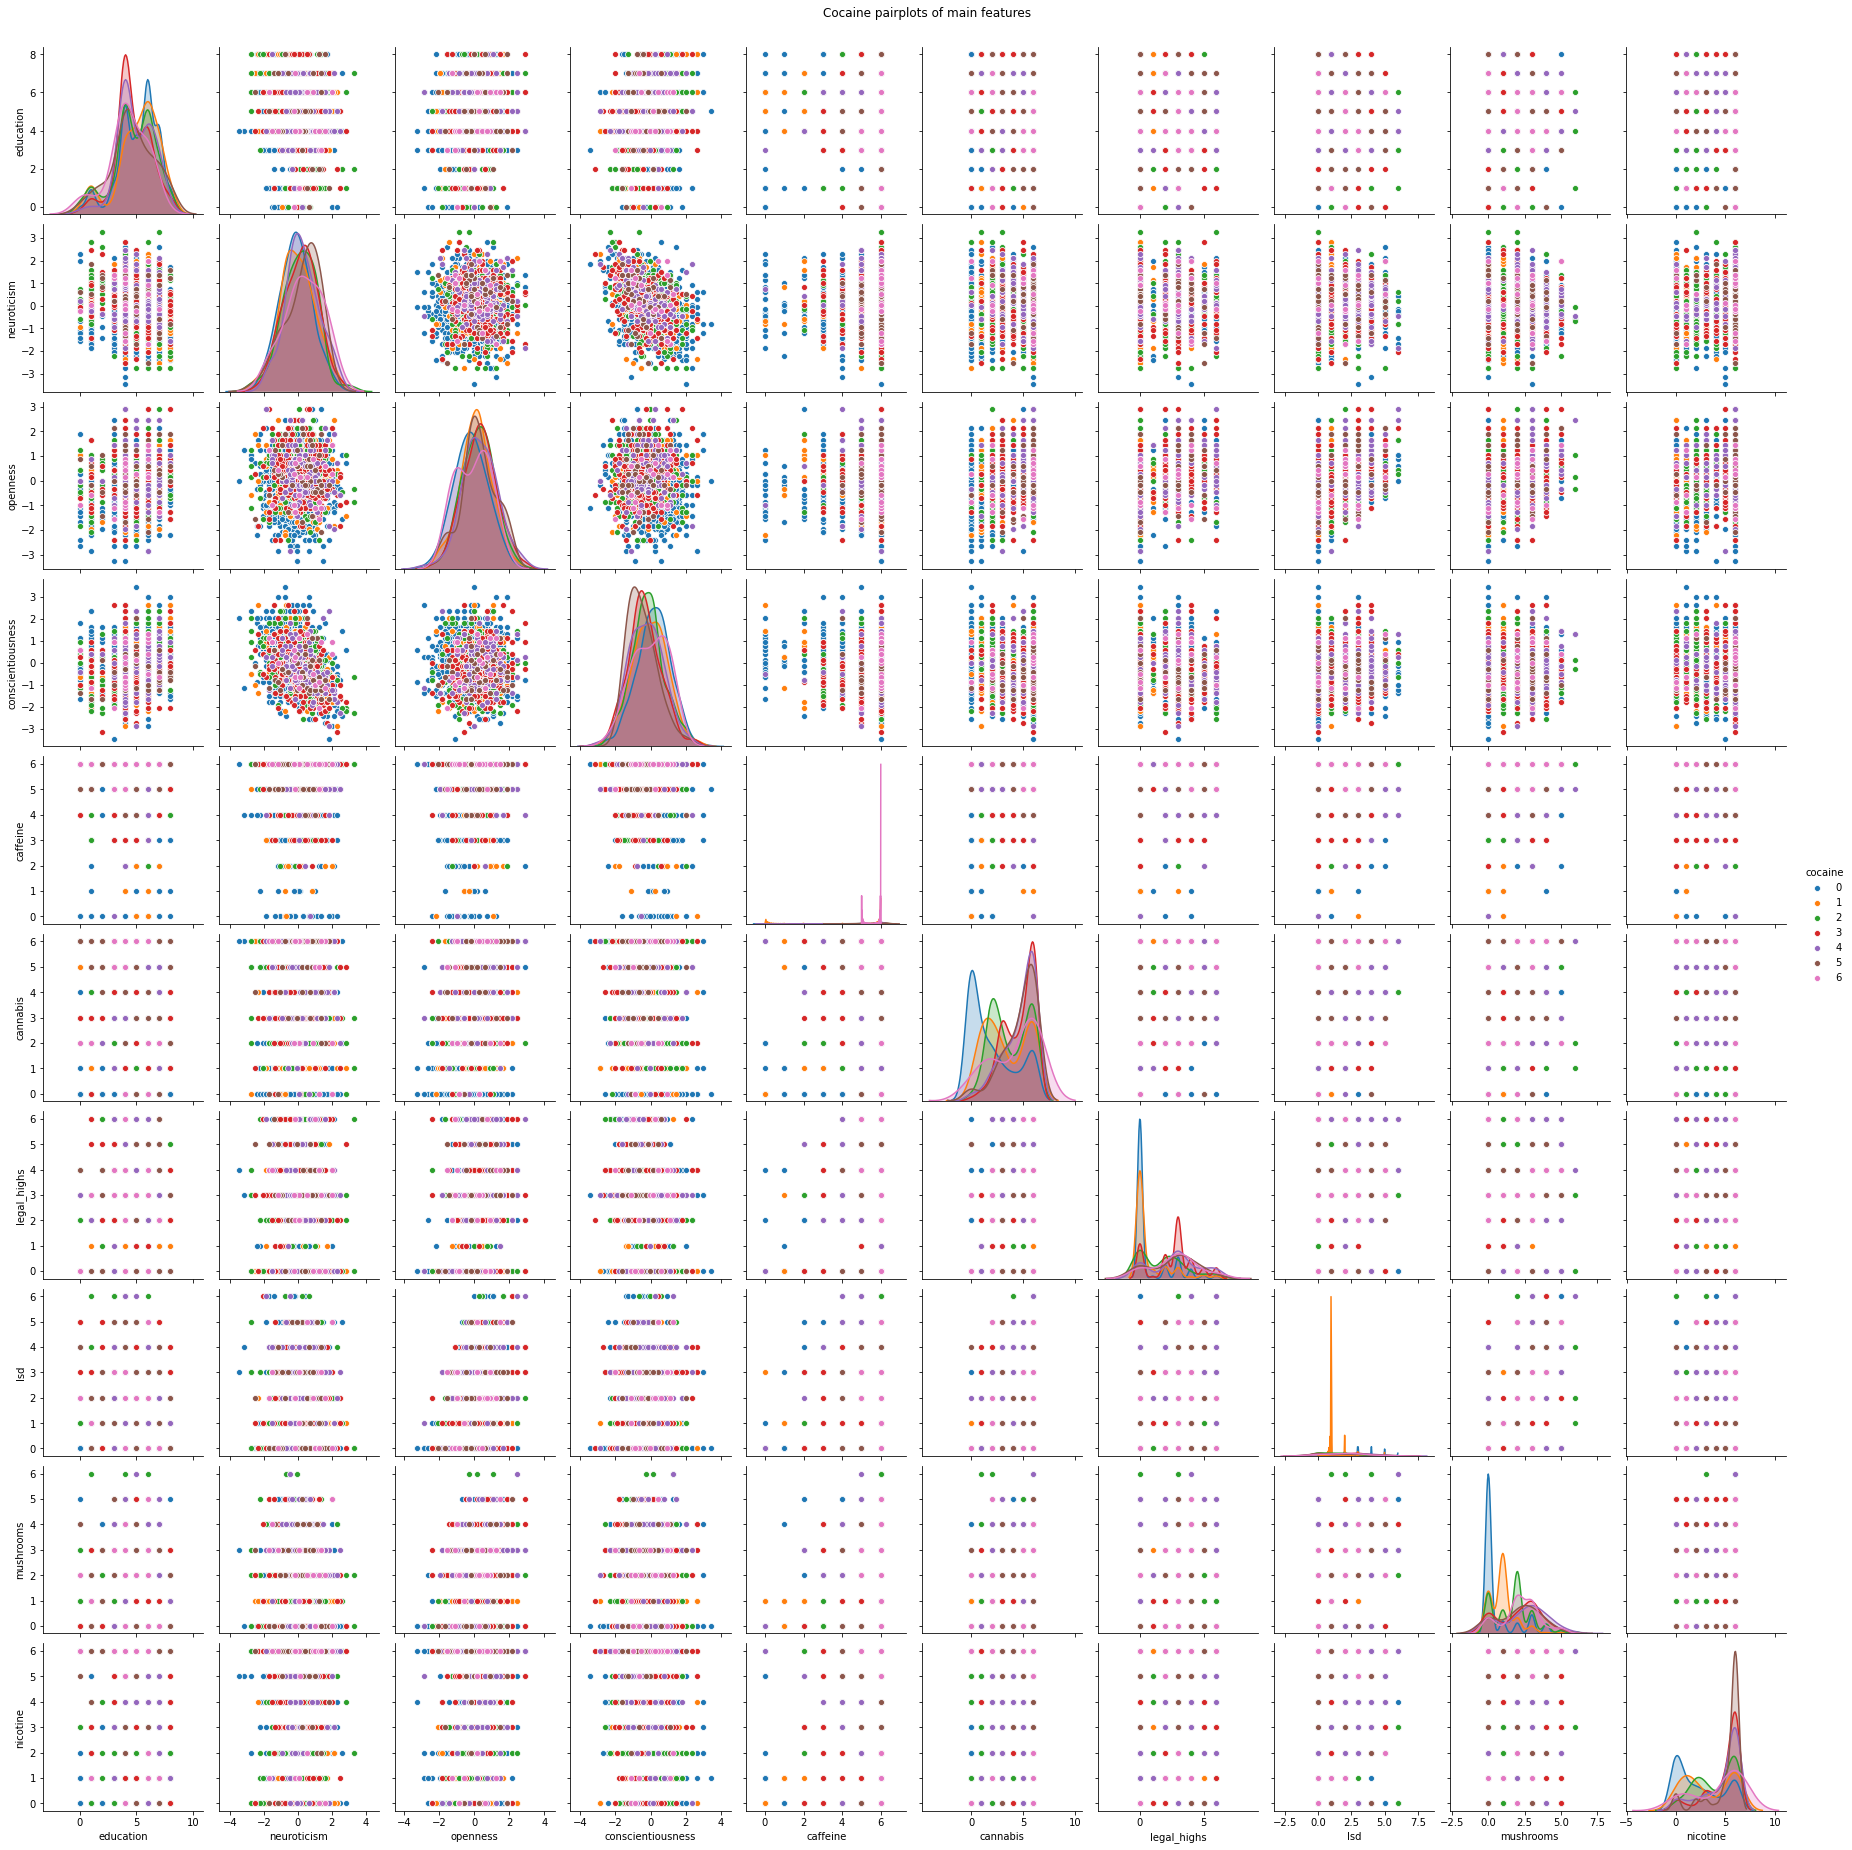

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_plot=sns.pairplot(ppcorefeatures, hue = 'cocaine')
sns_plot.fig.suptitle('Cocaine pairplots of main features', y=1.02)
sns_plot.savefig("cocaine_pairplot.png")

In [107]:
prettypairplots = df.drop(['amphetamines','amyl_nitrite_consumption','benzos',
                        'crack','ecstasy','heroin','katamine','meth','semeron',
                        'volatile_substance_abuse','id','impulsiveness',
                        'alcohol','country','extraversion','ethnicity',
                        'agreeableness','chocolate','sensation','age', 'gender',
                        'education','caffeine', 'cannabis','legal_highs','lsd', 
                        'mushrooms', 'nicotine'], 
                       axis=1)

In [108]:
prettypairplots.columns

Index(['neuroticism', 'openness', 'conscientiousness', 'cocaine'], dtype='object')

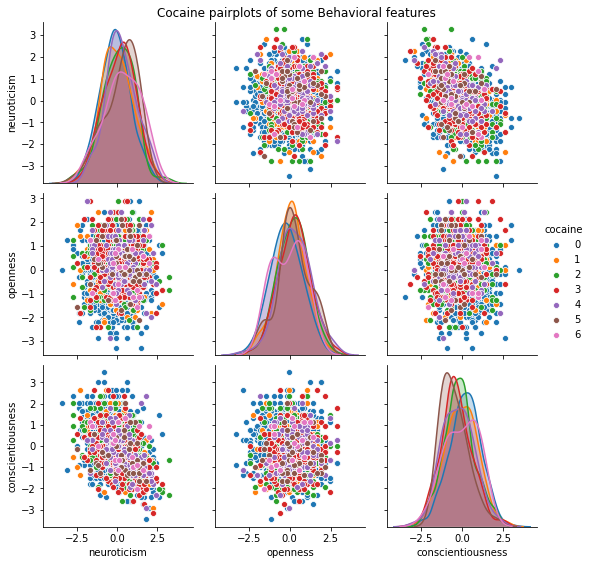

In [119]:
sns_plot=sns.pairplot(prettypairplots, hue = 'cocaine')
sns_plot.fig.suptitle('Cocaine pairplots of some Behavioral features', y=1.02)
sns_plot.savefig("prettypairplots.png")

In [128]:
spikeypairplots = df.drop(['amphetamines','amyl_nitrite_consumption','benzos',
                        'crack','ecstasy','heroin','katamine','meth','semeron',
                        'volatile_substance_abuse','id','impulsiveness',
                        'alcohol','country','extraversion','neuroticism', 
                        'openness', 'conscientiousness','ethnicity',
                        'agreeableness','sensation','age', 'gender',
                        'education'], axis=1)

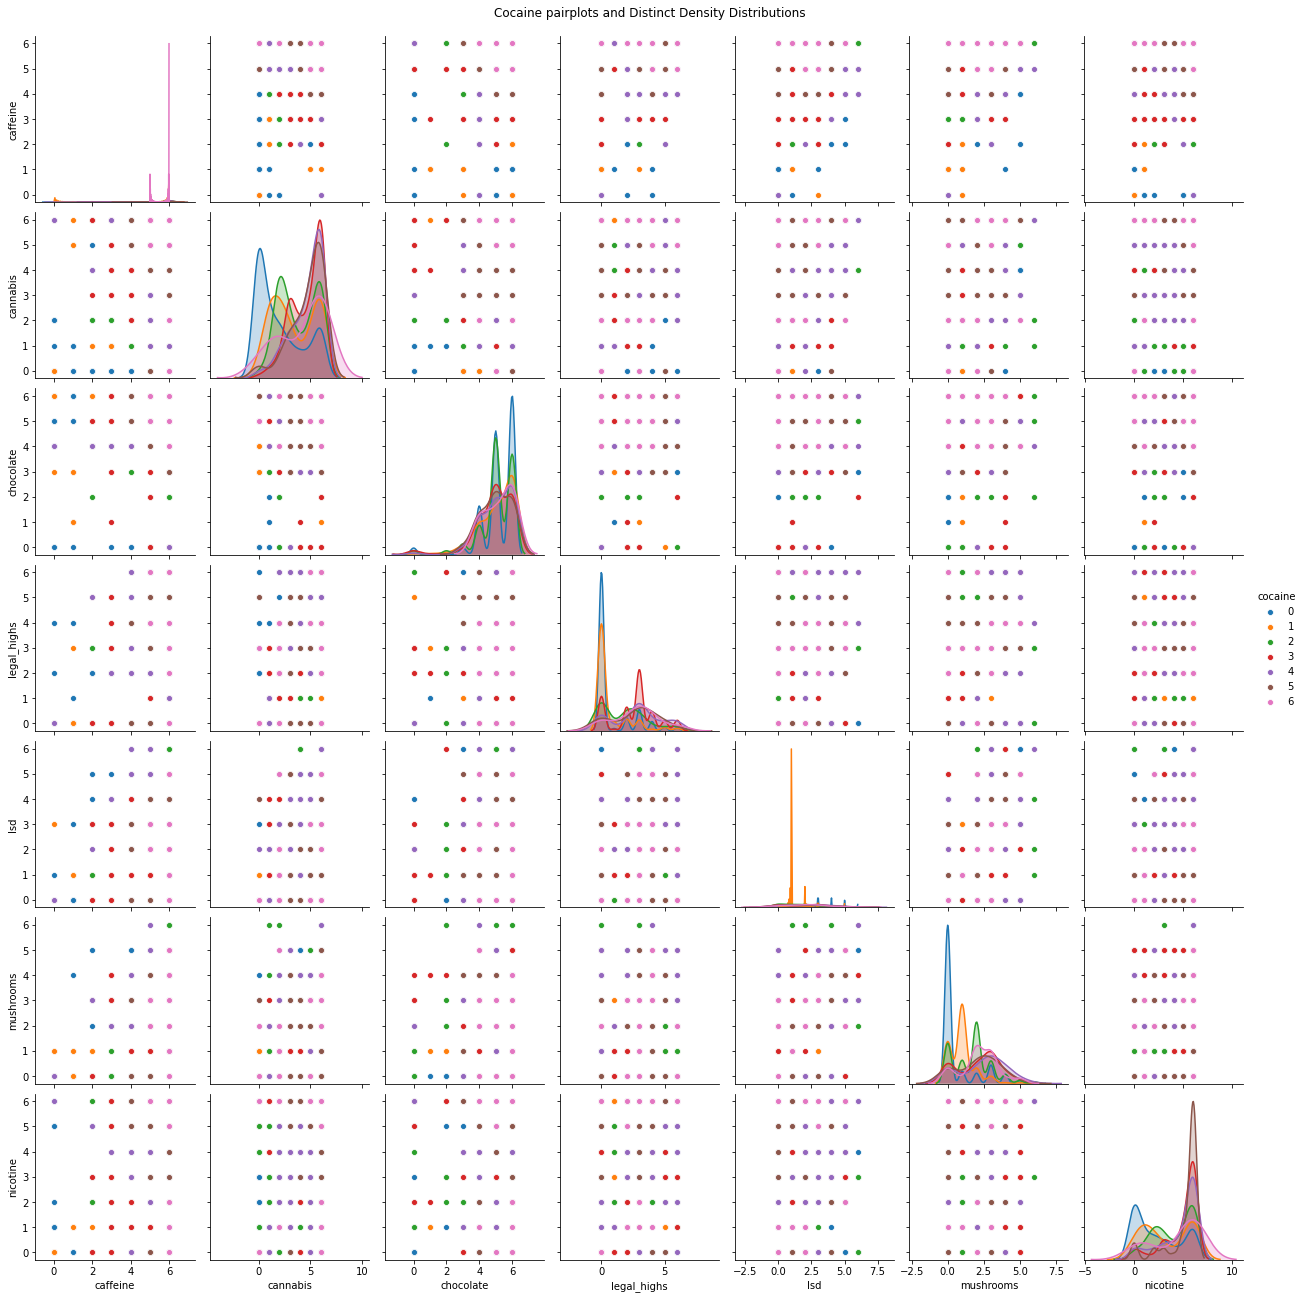

In [140]:
sns_plot=sns.pairplot(spikeypairplots, hue = 'cocaine')
sns_plot.fig.suptitle('Cocaine pairplots and Distinct Density Distributions', y=1.02)
sns_plot.savefig("spikeypairplots.png")

In [130]:
# files.download("cocaine_pairplot.png")
# files.download("prettypairplots.png")
files.download("spikeypairplots.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

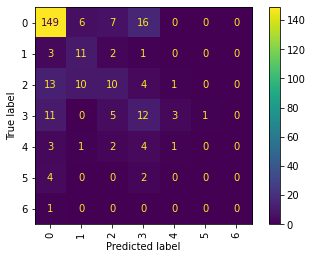

In [127]:
from sklearn.metrics import plot_confusion_matrix
p103CF = plot_confusion_matrix(pipeline103, X_test, y_test, values_format='.0f', xticks_rotation='vertical');

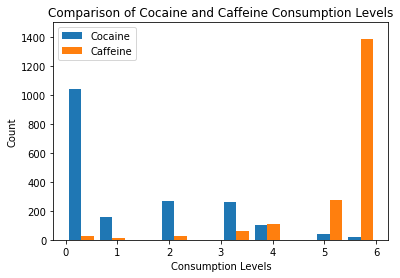

In [139]:
plt.hist([spikeypairplots['cocaine'],spikeypairplots['caffeine']],range=[0,6])
plt.title('Comparison of Cocaine and Caffeine Consumption Levels')
plt.xlabel('Consumption Levels')
plt.ylabel('Count')
plt.ylim(0,1500)
plt.legend(["Cocaine","Caffeine"])

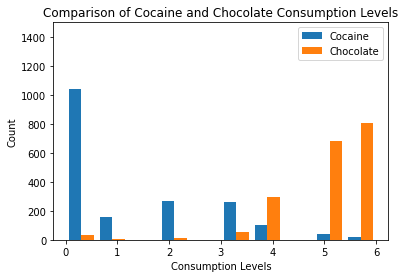

In [137]:
plt.hist([spikeypairplots['cocaine'],spikeypairplots['chocolate']],range=[0,6])
plt.title('Comparison of Cocaine and Chocolate Consumption Levels')
plt.xlabel('Consumption Levels')
plt.ylabel('Count')
plt.ylim(0,1500)
plt.legend(["Cocaine","Chocolate"])

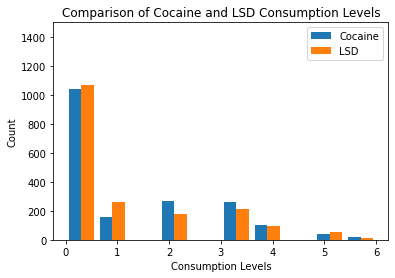

In [138]:
plt.hist([spikeypairplots['cocaine'],spikeypairplots['lsd']],range=[0,6])
plt.title('Comparison of Cocaine and LSD Consumption Levels')
plt.xlabel('Consumption Levels')
plt.ylabel('Count')
plt.ylim(0,1500)
plt.legend(["Cocaine","LSD"])

In [144]:
lookclosercaf6=spikeypairplots[spikeypairplots['caffeine']==6]
lookclosercaf6

,caffeine,cannabis,chocolate,cocaine,legal_highs,lsd,mushrooms,nicotine
0,6,0,5,0,0,0,0,2
1,6,4,6,3,0,2,0,4
2,6,3,4,0,0,0,1,0
4,6,3,6,0,1,0,2,2
5,6,0,4,0,0,0,0,6
...,...,...,...,...,...,...,...,...
1874,6,3,6,1,0,1,1,0
1877,6,5,5,3,2,0,0,6
1882,6,6,6,4,0,2,2,6
1883,6,6,5,0,3,3,3,4


In [147]:
lookclosercaf6.shape

(1385, 8)

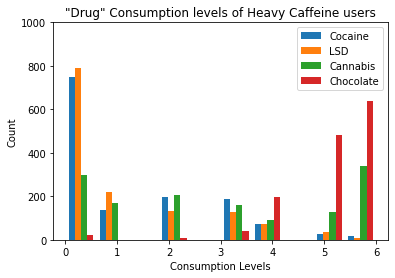

In [151]:
plt.hist([lookclosercaf6['cocaine'],lookclosercaf6['lsd'],
          lookclosercaf6['cannabis'],lookclosercaf6['chocolate']],range=[0,6])
plt.title('"Drug" Consumption levels of Heavy Caffeine users')
plt.xlabel('Consumption Levels')
plt.ylabel('Count')
plt.ylim(0,1000)
plt.legend(["Cocaine","LSD",'Cannabis','Chocolate'])

In [152]:
lookclosercoc6=spikeypairplots[spikeypairplots['cocaine']==6]
lookclosercoc6

,caffeine,cannabis,chocolate,cocaine,legal_highs,lsd,mushrooms,nicotine
42,6,2,4,6,2,0,0,1
54,6,2,6,6,3,1,1,1
183,6,0,5,6,3,0,0,6
329,6,2,6,6,0,2,2,6
534,6,2,4,6,0,2,2,6
607,6,6,6,6,4,2,3,1
802,6,2,4,6,4,5,5,6
823,6,6,6,6,3,5,2,2
940,6,6,6,6,0,2,2,0
979,6,5,6,6,6,0,0,6


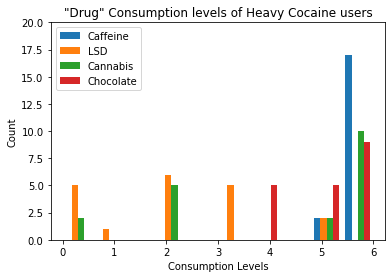

In [155]:
plt.hist([lookclosercoc6['caffeine'],lookclosercoc6['lsd'],
          lookclosercoc6['cannabis'],lookclosercoc6['chocolate']],range=[0,6])
plt.title('"Drug" Consumption levels of Heavy Cocaine users')
plt.xlabel('Consumption Levels')
plt.ylabel('Count')
plt.ylim(0,20)
plt.legend(["Caffeine","LSD",'Cannabis','Chocolate'])